In [2]:
using ConstrainedLasso, PyPlot

In [3]:
warming = readcsv(joinpath(Pkg.dir("ConstrainedLasso"),"docs/src/demo/misc/warming.csv"), header=true)[1];
year = warming[:, 1];
y    = warming[:, 2];
hcat(year, y)

166×2 Array{Float64,2}:
 1850.0  -0.375
 1851.0  -0.223
 1852.0  -0.224
 1853.0  -0.271
 1854.0  -0.246
 1855.0  -0.271
 1856.0  -0.352
 1857.0  -0.46 
 1858.0  -0.466
 1859.0  -0.286
 1860.0  -0.346
 1861.0  -0.409
 1862.0  -0.522
    ⋮          
 2004.0   0.45 
 2005.0   0.544
 2006.0   0.505
 2007.0   0.493
 2008.0   0.395
 2009.0   0.506
 2010.0   0.559
 2011.0   0.422
 2012.0   0.47 
 2013.0   0.499
 2014.0   0.567
 2015.0   0.746

In [4]:
function pava(v; w = ones(length(v)))
    n = length(v);
    if n != length(w)
        throw(DimensionMismatch("Lengths of values and weights mismatch"))
    end
    
    out = ones(n);
    j = 1;
    S = Dict(0 => 0, 1 => 1);
    vdash = Dict(1 => v[1]);
    wdash = Dict(1 => w[1]);
    @inbounds begin
        for i = 2:n
            j = j+1;
            vdash[j] = v[i];
            wdash[j] = w[i];
            while j > 1 && vdash[j] < vdash[j-1];
                vdash[j-1] = (wdash[j] * vdash[j] + wdash[j-1] * vdash[j-1]) /
                   (wdash[j] + wdash[j-1]);
                wdash[j-1] = wdash[j] + wdash[j-1];
                j = j-1;
            end
            S[j] = i;
        end
        for k = 1:j
            for l in S[k-1]+1 : S[k]
                out[l] = vdash[k];
            end
        end
    end
    return out
end

pava (generic function with 1 method)

In [12]:
out_pava = pava(y);

In [83]:
sigma = sqrt(sum((y - out_pava).^2)/166)

0.09498458976186688

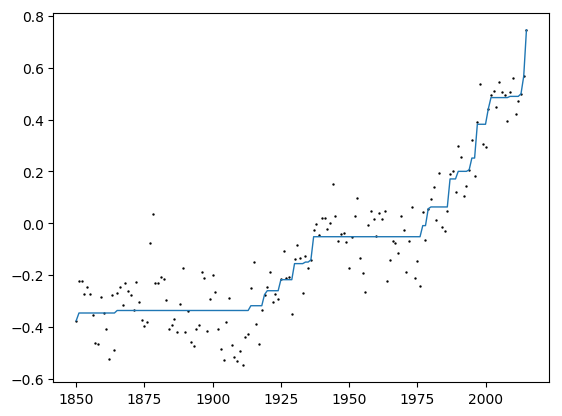

PyObject <matplotlib.collections.PathCollection object at 0x1327f7fd0>

In [5]:
plot(year, out_pava, linewidth = 1)
scatter(year, y, c = "black", s = 0.5)

In [ ]:
# using RCall
# R"require(neariso)";
# @rput y;
# R"out_neariso <- neariso(y, lambda = 0.5)$beta";
# out_neariso = (@rget out_neariso)[:];
# plot(year, out_neariso, linewidth = 1)

We minimize
$$
-\sum_{\gamma} q(\gamma)\log p(y|\theta,\sigma^2) p(\theta|\gamma,\sigma^2) + \sum_{\gamma} q(\gamma) \log q(\gamma)
$$
where $\log p(y|\theta,\sigma^2) = -\lVert y - \theta \rVert_2^2 / 2\sigma^2 - (n/2) \log \sigma^2 + constant$

and $\log p(\theta|\gamma,\sigma^2) = -\sum_{i=1}^{n-1} (\theta_{i+1} - \theta_{i})/\sigma[v_0\gamma_i + v_1(1-\gamma_i)] -\log \sigma[v_0\gamma_i + v_1(1-\gamma_i)]$

In [114]:
function bayes_iso(x; init = pava(x), v0 = 1e-1, v1 = 1e4, iter = 1000)
    out = init; n = length(x);
    q = 0.5 * ones(n);
    sigma = sqrt(sum((x - out).^2)/n);
    for i = 1:1000
        temp = out[2:end] - out[1:end-1];
        q = 1./( 1 + v0/v1 * exp.(temp/sigma*(1/v0-1/v1)) );
        q = (q - minimum(q))/(maximum(q) - minimum(q));
        tau = q/v0 + q/v1;
        b = -sum(temp .* q); c = -sum((x-out).^2);
        sigma = quadratic(2n,b,c)
        out = pava(y - [0;tau] * sigma + [tau;0] * sigma);
    end
    return out, sigma, q
end

bayes_iso (generic function with 1 method)

In [10]:
function quadratic(a, b, c)
    discr = b^2 - 4*a*c
    return (-b + sqrt(discr))/(2a)
end

quadratic (generic function with 1 method)

In [5]:
function bayes_iso2(x; init = pava(x), v0 = 1e-1, v1 = 1e4, iter = 1000)
    out = init; n = length(x);
    q = 0.5 * ones(n);
    sigma = sqrt(sum((x - out).^2)/n);
    for i = 1:1000
        temp = out[2:end] - out[1:end-1];
        q = 1./( 1 + v0/v1 * exp.(temp/sigma*(1/v0-1/v1)) );
        tau = q/v0 + q/v1;
        b = -sum(temp .* q); c = -sum((x-out).^2);
        sigma = quadratic(2n,b,c)
        out = pava(y - [0;tau] * sigma + [tau;0] * sigma);
    end
    return out, sigma, q
end

bayes_iso2 (generic function with 1 method)

In [78]:
out_bayesp1 = bayes_iso2(y, v0 = 1e1);
out_bayes0 = bayes_iso2(y, v0 = 1e0);
out_bayes1 = bayes_iso2(y, v0 = 1e-1);
out_bayes2 = bayes_iso2(y, v0 = 1e-2 * 5);

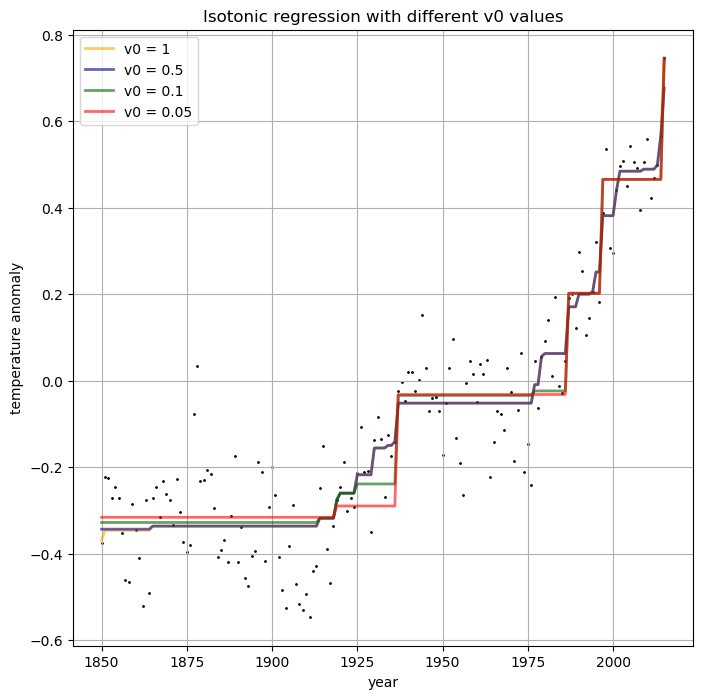

In [231]:
out1 = bayes_iso2(y, v0 = 1e1, v1 = 1e6);
out2 = bayes_iso2(y, v0 = 1e0, v1 = 1e6);
out3 = bayes_iso2(y, v0 = 1e-1, v1 = 1e6);
out4 = bayes_iso2(y, v0 = 1e-2 * 5, v1 = 1e6);
fig, ax = subplots(figsize=(8,8))
ax[:plot](year, out1[1], "r-", linewidth=2, color = "orange", label="v0 = 1", alpha=0.6)
ax[:plot](year, out2[1], "r-", linewidth=2, color = "darkblue", label="v0 = 0.5", alpha=0.6)
ax[:plot](year, out3[1], "r-", linewidth=2, color = "darkgreen", label="v0 = 0.1", alpha=0.6)
ax[:plot](year, out4[1], "r-", linewidth=2, color = "red", label="v0 = 0.05", alpha=0.6)
ax[:scatter](year, y, s = 1, color = "black")
ax[:legend](loc="upper left")
xlabel("year"); ylabel("temperature anomaly")
title("Isotonic regression with different v0 values")
grid("on")

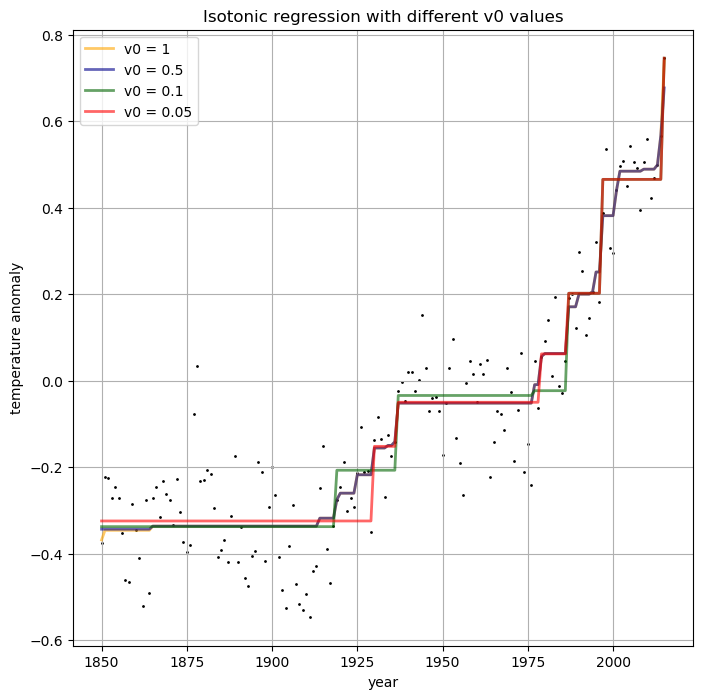

In [192]:
fig, ax = subplots(figsize=(8,8))
ax[:plot](year, out_bayesp1[1], "r-", linewidth=2, color = "orange", label="v0 = 1", alpha=0.6)
ax[:plot](year, out_bayes0[1], "r-", linewidth=2, color = "darkblue", label="v0 = 0.5", alpha=0.6)
ax[:plot](year, out_bayes1[1], "r-", linewidth=2, color = "darkgreen", label="v0 = 0.1", alpha=0.6)
ax[:plot](year, out_bayes2[1], "r-", linewidth=2, color = "red", label="v0 = 0.05", alpha=0.6)
ax[:scatter](year, y, s = 1, color = "black")
ax[:legend](loc="upper left")
xlabel("year"); ylabel("temperature anomaly")
title("Isotonic regression with different v0 values")
grid("on")

In [250]:
function model_selection(out; v1 = 1e4, thresh = 0.1)
    t = out[1]; s = out[2]; d = t[2:end] - t[1:end-1];
    ind = (d .> thresh * s);
    first_term = sum((y-t).^2)/2/s^2;
    second_term = sum(d[ind]/s/v1);
    third_term = sum(ind) * log(sigma * v1);
    return first_term + second_term + third_term
end

model_selection (generic function with 1 method)

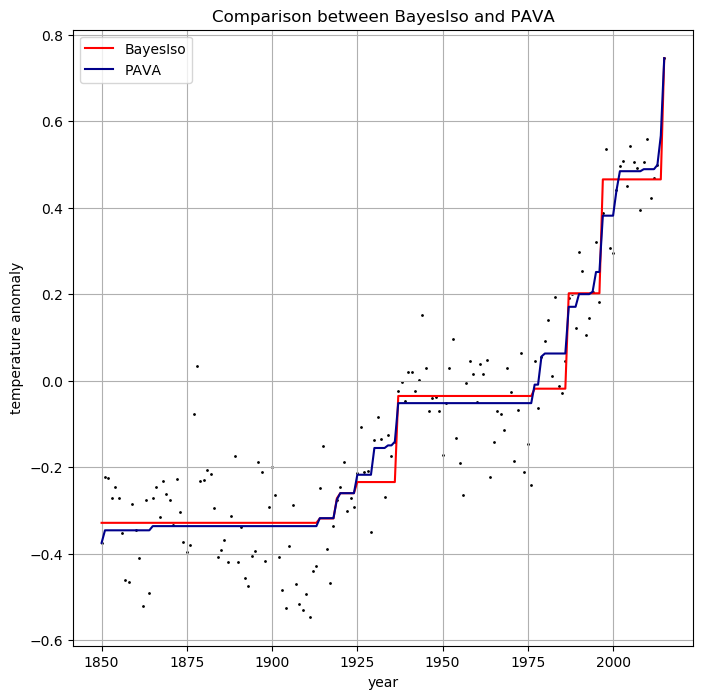

In [13]:
fig, ax = subplots(figsize=(8,8))
res = bayes_iso2(y, v0 = v0_range[10])
ax[:plot](year,res[1], color = "red", label="BayesIso")
ax[:plot](year,out_pava, color = "darkblue", label="PAVA")
ax[:scatter](year,y, s = 1, color = "black")
xlabel("year");
ylabel("temperature anomaly")
title("Comparison between BayesIso and PAVA")
ax[:legend](loc="upper left")
grid("on")

In [261]:
v0_range = 0.8.^(1:20)
out = zeros(20);
for i = 1:20
    out[i] = model_selection(bayes_iso2(y, v0 = v0_range[i], v1 = 1e4))
end
out

20-element Array{Float64,1}:
 289.001
 289.175
 289.398
 282.826
 276.192
 276.469
 237.666
 232.251
 226.691
 226.928
 200.283
 200.283
 200.283
 213.996
 220.852
 234.565
 255.134
 255.134
 268.846
 268.846

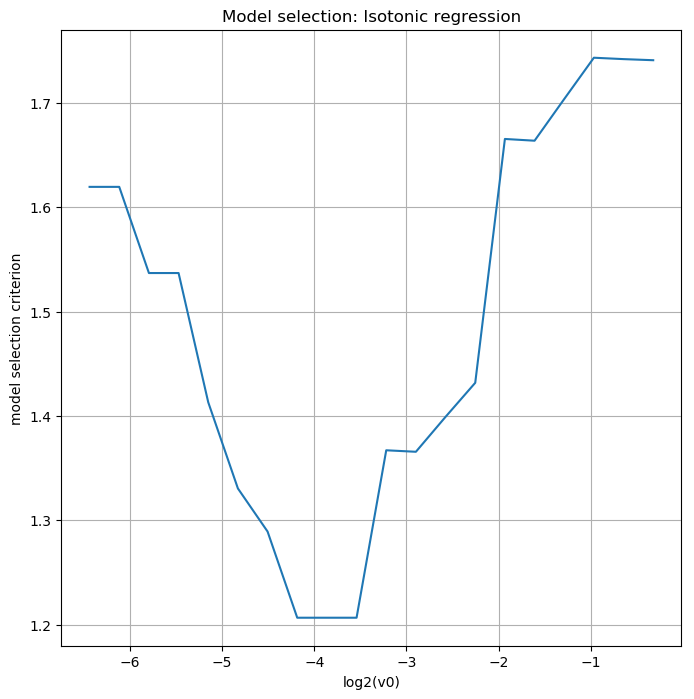

In [262]:
fig, ax = subplots(figsize=(8,8))
ax[:plot](log2.(v0_range),out/166);
xlabel("log2(v0)")
ylabel("model selection criterion")
title("Model selection: Isotonic regression")
grid("on")